In [1]:
# load packages
import mne as mne
mne.set_log_level('error')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import mne
import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from autoreject import AutoReject

import os

C:\Users\Kya\AppData\Local\Temp\ipykernel_2636\2709693847.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
p_id = 'p008'

c:\Users\Kya\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


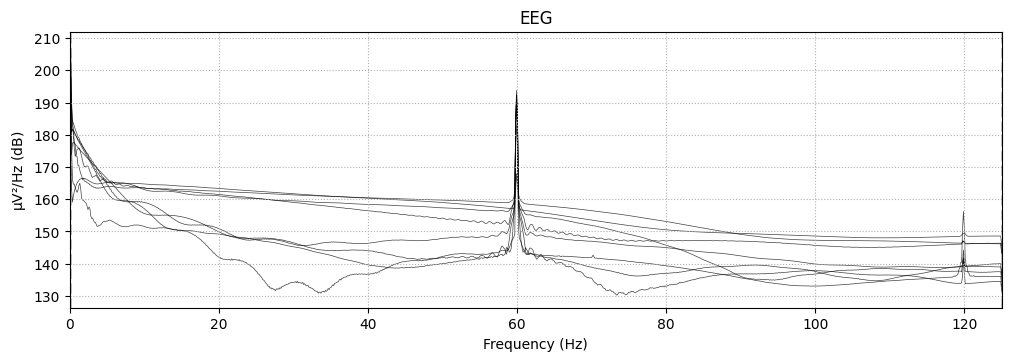

In [3]:
# load data from .csv file name 'combined_recording_##########.csv' from data/recordings folder, use columns 0-7, 17, 19
data = pd.read_csv(f'data/training/{p_id}.csv', usecols=[0,1,2,3,4,5,6,7,18,20])

# channel info (check electode placement/name and columsn in data)
ch_names = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'Type', 'TimeStamp']
sfreq = 250  # sampling frequency in Hz

# channel types (8 channels of EEG data and 2 for image type and stimulus time)
ch_types = ['eeg'] * 8 + ['misc'] * 2

# create info object and raw data object
info = mne.create_info(ch_names, sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data.T, info)
raw.plot_psd()
plt.show()

In [4]:
# Preprocessing params

# Filter settings
low_cut = .1
low_cut_ica = 1
high_cut = 30

# ICA
tstep = 1.0
tmin_ica = 0.0
ica_rand_state = 42
ica_n_components = 0.99

# AutoReject
n_jobs = -1
ar_rand_state = ica_rand_state

# Epoch settings
tmin =  -.200  
tmax =  1.000
baseline = (tmin, 0)

In [5]:
# rename channels to match MNE conventions
raw = raw.rename_channels(mapping={'CH1': 'Fz', 'CH2': 'C3', 'CH3': 'Cz', 'CH4': 'C4', 'CH5': 'Pz', 'CH6': 'PO7', 'CH7': 'Oz', 'CH8': 'PO8'})


In [6]:
# apply filters to raw data
raw.set_montage('standard_1020')

raw.apply_function(lambda x: x * 1e-6)

raw_filt = raw.copy().filter(low_cut, high_cut)

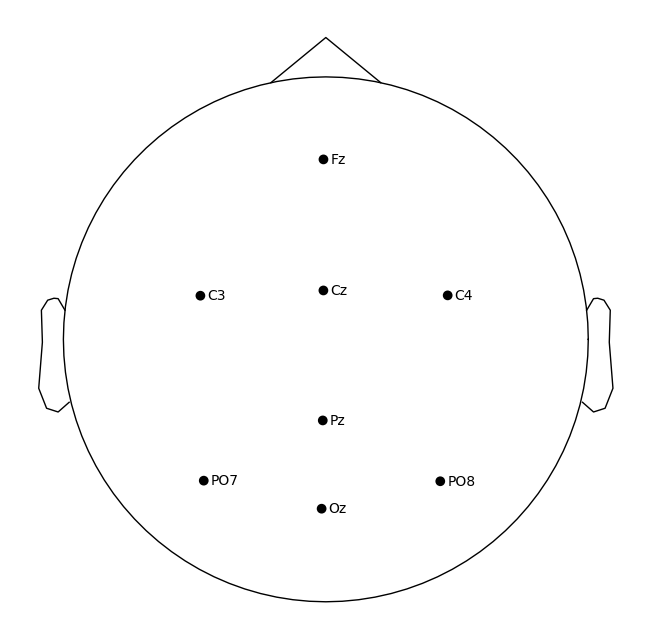

In [7]:
# plot raw data electrode locations and names
raw_plotted = raw.plot_sensors(show_names=True);

c:\Users\Kya\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


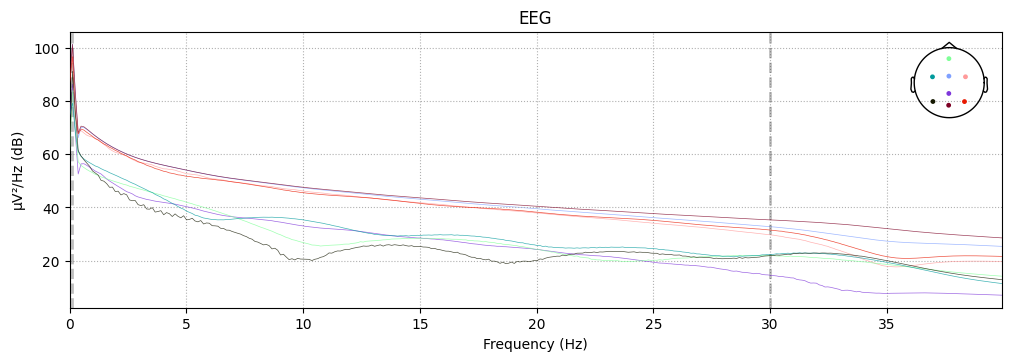

In [8]:
raw_filt.plot_psd(fmin=0, fmax=40)
plt.show()

In [9]:
# save filtered raw data
# raw_filt.save('data/training/'  + participant_id + '-filtered.fif', overwrite=True)

In [10]:
# filter a new copy of the raw data for ICA
raw_filt_ica = raw.copy().filter(low_cut_ica, high_cut)

In [11]:
# Break raw data into 1 s epochs
events_ica = mne.make_fixed_length_events(raw_filt_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_filt_ica, events_ica,
                        tmin=tmin, tmax=tmax,
                        baseline=baseline,
                        preload=True)

In [12]:
# Instantiate 
ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info,
                                     eeg=True,
                                     eog=False
                                     ),
                n_jobs=1,
                verbose=False
                )

# Fit
ar.fit(epochs_ica)

# Generate log
reject_log = ar.get_reject_log(epochs_ica)

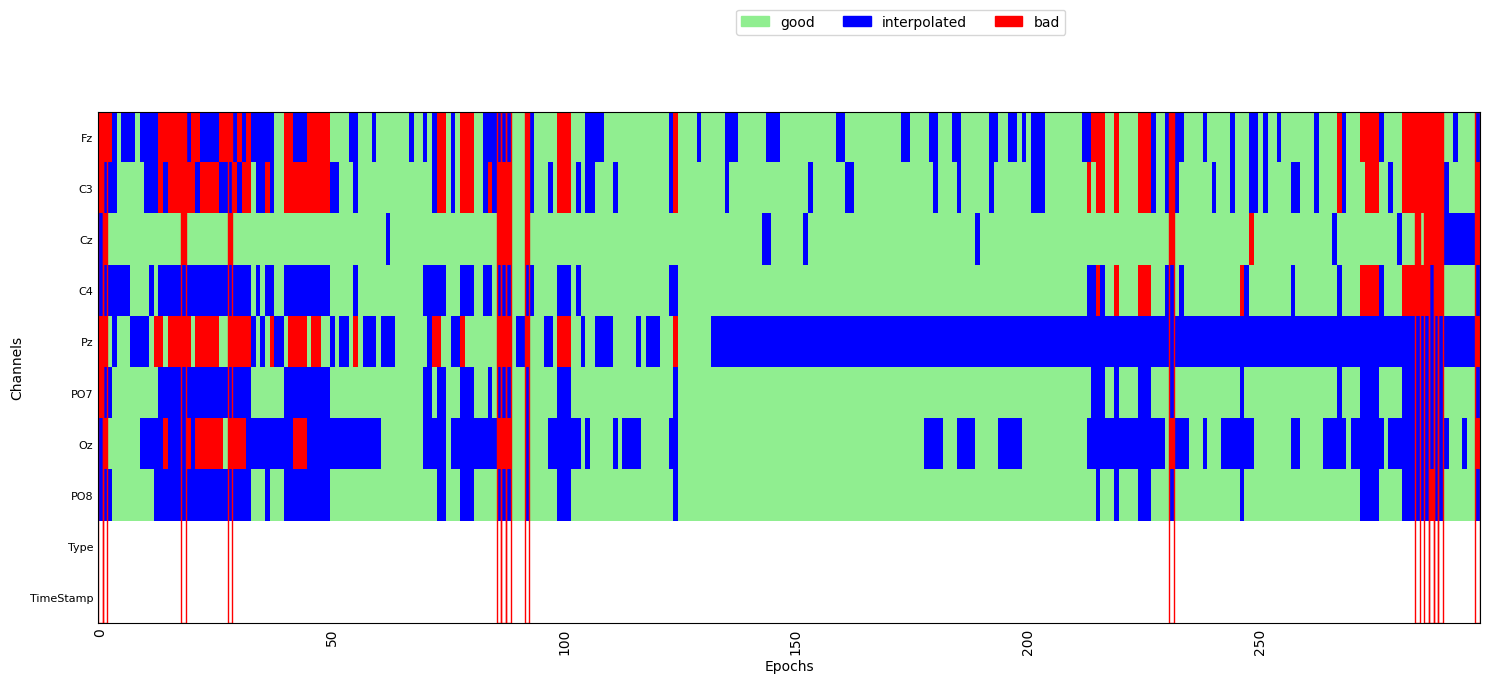

<function matplotlib.pyplot.show(close=None, block=None)>

In [13]:
# Visualize the rejection log
fig, ax = plt.subplots(figsize=[15, 7])
reject_log.plot(orientation='horizontal', ax=ax, aspect='auto', show_names=True)
plt.show

In [14]:
#ICA 

# Instantiate
ica = mne.preprocessing.ICA(n_components=ica_n_components,
            random_state=ica_rand_state,)

# Fit
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,7 iterations on epochs (28583 samples)
ICA components,3
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


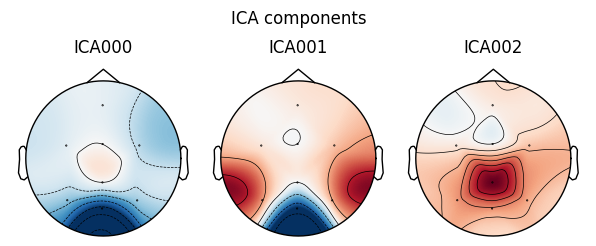

In [15]:
ica.plot_components();

In [16]:
# find bad components

ica.exclude = []
num_excl = 0
max_ic = 2
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=[chan for chan in raw.info['ch_names'] if 'EOG' in chan], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step  # lower the threshold by z_step each iteration

# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))

# print the components to exclude
print("Components to exclude: " + str(eog_indices))

Final z threshold = 1.25
Components to exclude: [0, 2]


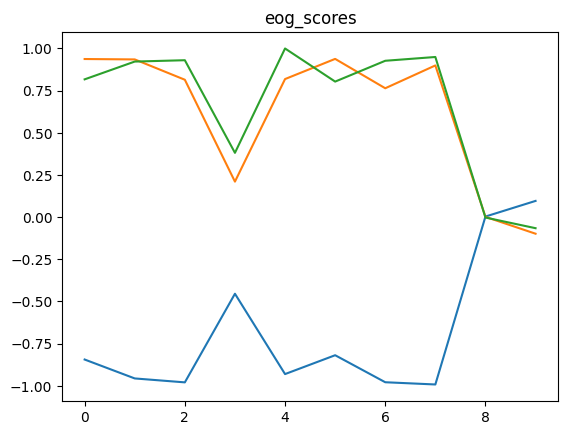

In [17]:
# plot eog_scores
plt.figure()
plt.plot(eog_scores)
plt.title('eog_scores')
plt.show()

In [18]:
# save ICA object 
# ica.save('data/training/'  + participant_id + '-ica.fif')

In [19]:
# find events and separate into categories
events = mne.find_events(raw_filt, stim_channel='Type')

# create new lists for each event type
events_real = []
events_ai = []

# separate events base of value in type channel
for e in events:
    if e[2] == 1:
        events_real.append(e)
    elif e[2] == 2:
        events_ai.append(e)

# print number of events in each category
print('Number of real events: ' + str(len(events_real)))
print('Number of ai events: ' + str(len(events_ai)))


Number of real events: 95
Number of ai events: 96


In [20]:
# remapping events to match MNE conventions

# create dictionary to map events to
events_dict = {'real': 1, 'ai': 2}

# make a copy of events array
events_remapped = events.copy()

# create a dict to store the number of events in each category
event_counts = {}

# loop through the dictionary and remap the events array using a mask, then print the length of each category
for k, v in events_dict.items():
    mask = np.isin(events_remapped[:,2], v)
    event_counts[k] = len(events_remapped[mask])
    print(f"Category {str(k)}: {event_counts[k]}")

Category real: 95
Category ai: 96


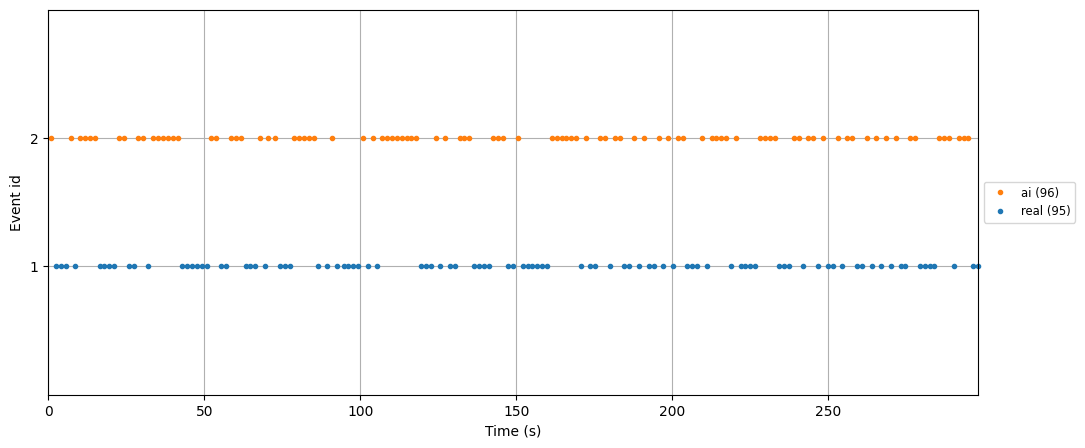

In [21]:
# plot the remapped events array
fig, ax = plt.subplots(figsize=[15, 5])
mne.viz.plot_events(events_remapped, raw_filt.info['sfreq'], event_id=events_dict, axes=ax);

In [22]:
# make epochs
epochs = mne.Epochs(raw_filt, events_remapped, tmin=tmin, tmax=tmax, baseline=baseline, proj=False, detrend=1, preload=True, event_repeated='merge',
                    reject = dict(eeg=1e-3))

print(epochs)

labels = epochs.events[:, -1:]
print(labels.T)

psd = epochs.compute_psd(method='multitaper', tmin=tmin, tmax=tmax, fmin=low_cut, fmax=high_cut, picks='eeg')




<Epochs |  167 events (all good), -0.2 – 1 s, baseline -0.2 – 0 s, ~3.9 MB, data loaded,
 '1': 82
 '2': 85>
[[2 2 1 2 1 1 2 2 2 2 2 2 2 1 1 1 2 2 1 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 2 2
  2 2 1 1 2 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 2 2 1 1 1 1
  2 2 2 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 1 2 1 1 2 2 1 2 2 1 1 2 1 2 1 1 2 1
  2 1 2 2 1 1 1 2 1 2 2 2 2 1 2 1 1 1 1 2 2 2 1 1 1 2 2 1 2 2 1 2 1 1 2 1
  2 2 1 1 2 1 2 1 2 1 2 1 2 2 1 1 1 1 2 2 2 1 1]]


In [23]:
psds = []

psd = 10 * np.log10(psd)
reshaped_psd = psd.reshape(len(psd), len(psd[0]) * len(psd[0][0])) # convert the data into a two dimensional array
psds.append(reshaped_psd)



In [24]:
clf = RidgeClassifier()
sam = np.asarray(psds)
lab = np.asarray(labels.T)
preds = np.empty(len(labels))

sam_train, sam_test, lab_train, lab_test = train_test_split(sam[0], lab[0], test_size=0.25, random_state=42)
clf.fit(sam_train, lab_train)
savefile = '../data/classifier_save.sav'
# pickle.dump(clf, open(savefile, 'wb'))
preds = clf.predict(sam_test)

report = classification_report(lab_test, preds)
acc = accuracy_score(lab_test, preds)
print(acc)
print(lab_test)
print(preds)
print("The accuracy for this participant: " + str(acc * 100) + "% \n")

0.6190476190476191
[2 2 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1 2 2 2 1 2 2 2 1 1 1 2 2 1 1 1
 1 1 1 1 2]
[1 1 1 1 1 2 2 1 2 1 2 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 2 2 1 1 1 1 1 2 2 2 1
 1 1 1 1 2]
The accuracy for this participant: 61.904761904761905% 



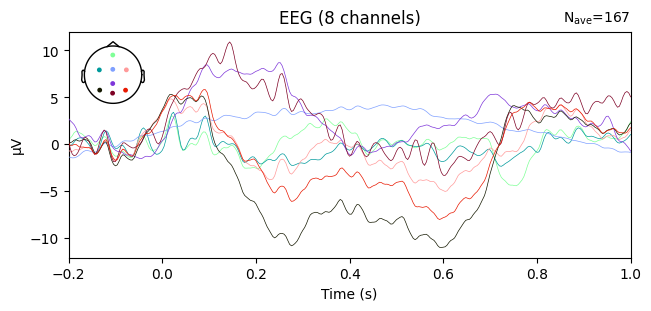

In [25]:
# average and plot the epochs
evoked = epochs.average()
evoked.plot()
plt.show()

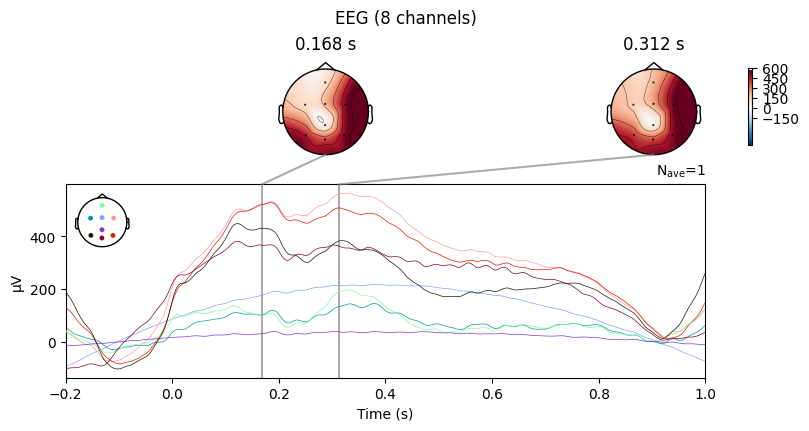

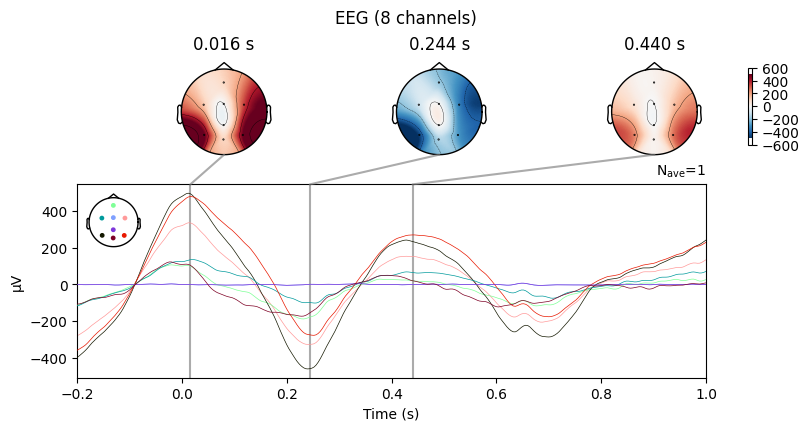

In [26]:
# separate epochs into real and ai
real = epochs[1].average()
ai = epochs[2].average()

fig1 = real.plot_joint()
fig2 = ai.plot_joint()

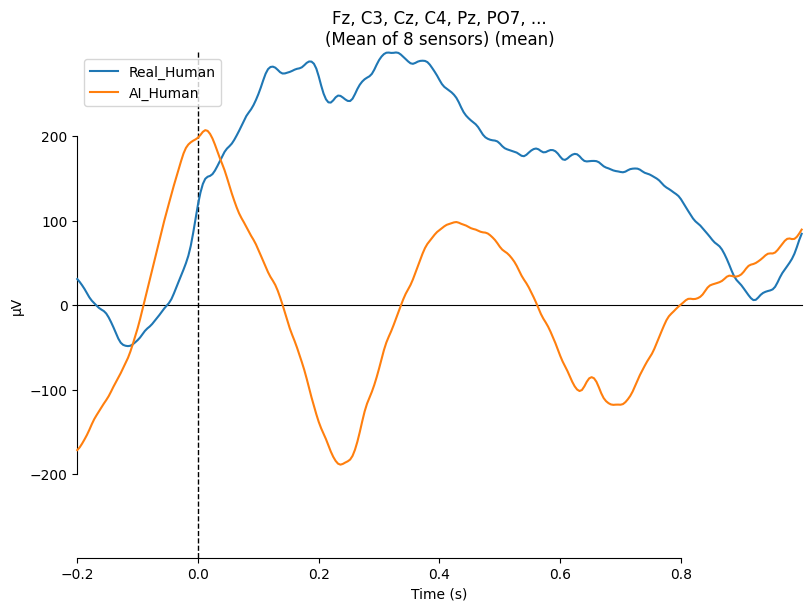

[<Figure size 800x600 with 1 Axes>]

In [27]:
# plot the average of the real and ai epochs
evokeds = dict(Real_Human=real, AI_Human=ai)
picks = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean")

In [28]:
# save the two conditions into one, comment to later indentify the condition
real.comment = 'Real_Human'
ai.comment = 'AI_Human'
all_evokeds = [real, ai]

# save the evokeds data
mne.write_evokeds('data/training/' + p_id + '-evoked.fif', all_evokeds, overwrite=True)